In [1]:
import os
import gc
import time
import math
import datetime
from math import log, floor
from sklearn.neighbors import KDTree
import copy
import random

import numpy as np
import modin.pandas as pd
from pathlib import Path
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm.notebook import tqdm as tqdm
from scipy.signal import find_peaks

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import pywt
from statsmodels.robust import mad

import scipy
import statsmodels
from scipy import signal
import statsmodels.api as sm
from fbprophet import Prophet
from scipy.signal import butter, deconvolve
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.utilities.dataframe_functions import roll_time_series

from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

# from autox import AutoX

import warnings
warnings.filterwarnings("ignore")

In [2]:
#特征处理

from util import wspd_clip #将风速clip在3-12之间
from util import get_time_week #一周的时间
from util import get_time_day #一天的时间
from util import get_time_hour #一天的小时计数
from util import time_triangle #时间的三角函数处理
from util import tmp_anomaly_replace #异常值处理-温度替换
from util import Etmp_anomaly_process #异常值处理-外部温度-3σ
from util import Itmp_anomaly_process #异常值处理-内部温度-3σ
from util import fillna_0 #填充所有nan为0
from util import remove_abnormal #在fillna_0之后，去除训练集中的所有异常值
from util import dataset_split

# 要加feat_columns的
from util import Group_Normalization #对每台机器单独做归一化 data,feat_columns
from util import raw_data_peak # 返回每列的峰值列表[[],[]] data,feat_columns
from util import unique_avg_prtv #求某些列相同值的prtv均值
from util import unique_avg_patv #求某些列相同值的patv均值
from util import no_change #数据有多长时间没有发生变化

# 要加feat_columns和li的
from util import lag_feature #制作lag特征, data,feat_columns,li
from util import self_minus #不同间隔距离的自减 data,feat_columns,li
from util import rolling_mean # data,feat_columns,li
from util import rolling_max # data,feat_columns,li
from util import rolling_min # data,feat_columns,li

#ts_fresh的
# cid:'TurbID', csort:'time_week'
from util import raw_extract
from util import filtered_extract
from util import roll_extract

#标记上地理位置的组 data,location_data
from util import location_id

# 打包运行
from util import test_data_func
from util import test_data_fc_func
from util import test_data_fc_li_func
from util import test_lag

In [3]:
# 画出n台（可以是一台）机器的某列数据，每一天
# pandas数据，某列的名称（字符串），包含了TurbID的数组（可以是[1]这样子）
from util import plot_data_TurbID #data, column, li

# 画出n台（可以是一台）机器的某列数据，在某个时段
# pandas数据，某列的名称（字符串），时刻[start_time, end_time] 1-xxx
from util import plot_data_time #data, column, li, time

In [4]:
#预测
from util import lgb_ #train_feat, train_label, test_feat, test_label
from util import lgb_cv
from util import lgb_test #gbm, test_feat

# 预测后
from util import pred_peak #寻找预测值的峰值
from util import group #根据预测情况差异大小分为2组 data,far

# 将每台机器的预测值均值与label均值做比较
# 输入test_individual_feat和test_individual_label
from util import avg_compare_turb #feat, label, gbm

# 每个时刻的所有机器的均值，与每个时刻所有机器的label作比较
from util import avg_compare_time #feat, label, gbm

In [5]:
# data = pd.read_csv('sdwpf_baidukddcup2022_full.csv')
data = pd.read_csv('wtbdata_245days_normal_all.csv')
location_data = pd.read_csv('sdwpf_baidukddcup2022_turb_location.csv')

# EDA

In [6]:
data = data.reset_index()
data['time_idx'] = data.groupby('TurbID')['index'].rank().astype(int)
# data = data.drop('index',axis=1)
# data = data.drop(data.groupby('TurbID').tail(27).index)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4727520 entries, 0 to 4727519
Data columns (total 15 columns):
 #   Column    Dtype  
---  ------    -----  
 0   index     int64  
 1   TurbID    int64  
 2   Day       int64  
 3   Tmstamp   object 
 4   Wspd      float64
 5   Wdir      float64
 6   Etmp      float64
 7   Itmp      float64
 8   Ndir      float64
 9   Pab1      float64
 10  Pab2      float64
 11  Pab3      float64
 12  Prtv      float64
 13  Patv      float64
 14  time_idx  int64  
dtypes: float64(10), int64(4), object(1)
memory usage: 541.0+ MB


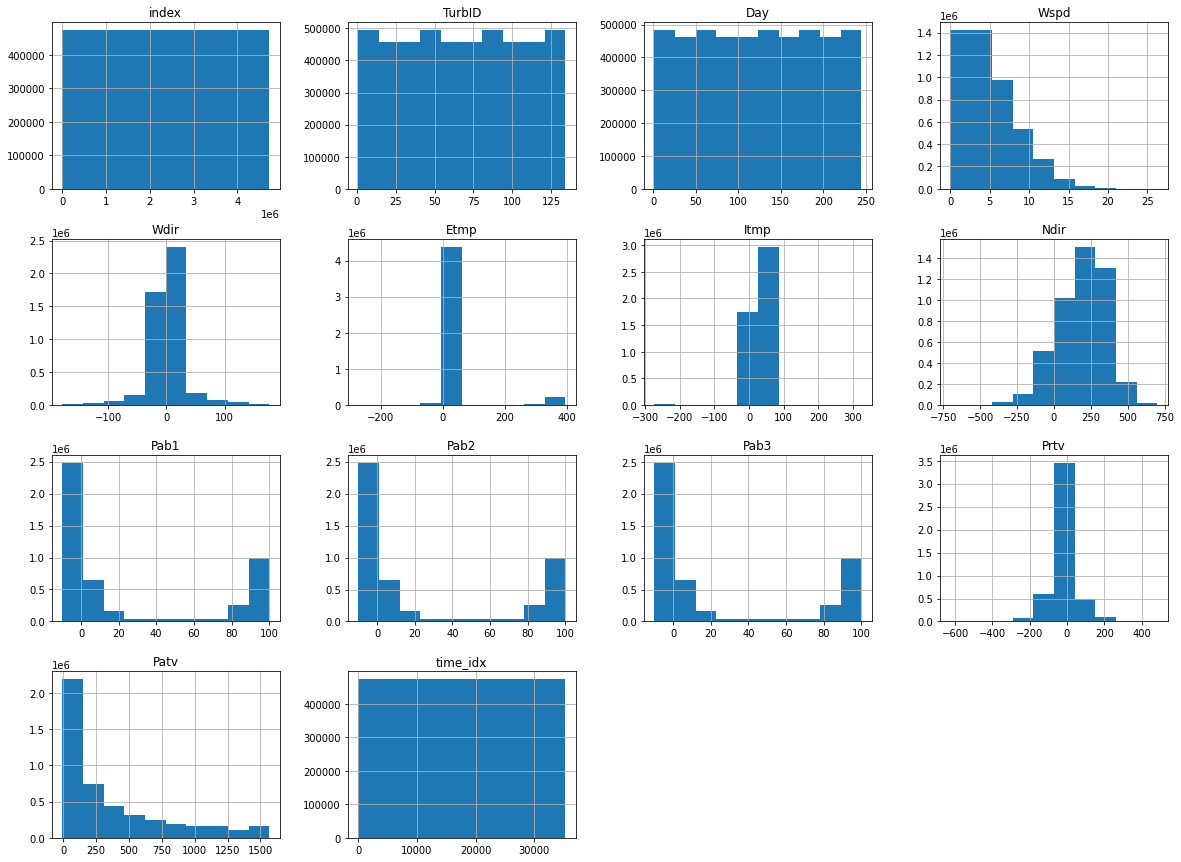

In [11]:
data.hist(figsize=(20,15));

<AxesSubplot:>

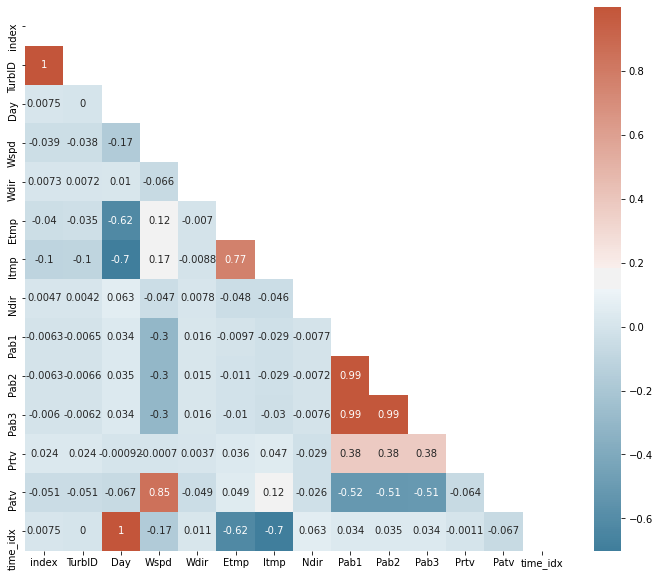

In [13]:
# corr = data.corr() # pearson
# corr = data.corr('kendall')
corr = data.corr('spearman')
f, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

In [37]:
for index, row in data.iterrows():
    row.Itmp += 3*random.random()
    if row.Itmp <= 30:
        row.Itmp = data.iloc[index-1].Itmp + 3*random.random()
    if row.Etmp <= 0:
        row.Etmp = data.iloc[index-1].Etmp
    data.iloc[index] = row
    
    if index > 2700:
        break

In [33]:
data

,index,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,time_idx
0,0,1,1,00:00,12.23,-0.83,29.08,41.90,-23.73,1.07,1.07,1.07,-0.21,1549.53,1
1,1,1,1,00:10,11.58,-3.32,29.01,42.01,-23.70,1.06,1.06,1.06,-0.25,1549.71,2
2,2,1,1,00:20,11.21,-1.38,29.17,42.24,-28.84,1.04,1.04,1.04,-0.25,1534.77,3
3,3,1,1,00:30,10.84,0.06,29.46,42.43,-31.39,1.03,1.03,1.03,-0.25,1508.20,4
4,4,1,1,00:40,11.03,2.03,29.82,42.77,-31.39,1.03,1.03,1.03,-66.01,1517.76,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3550459,3550459,134,184,23:10,2.36,-74.19,7.30,11.70,238.59,90.39,90.37,90.36,-0.30,-0.30,26492
3550460,3550460,134,184,23:20,1.72,-67.92,7.21,11.70,238.59,90.39,90.37,90.36,-0.30,-0.30,26493
3550461,3550461,134,184,23:30,1.46,-59.15,7.10,11.70,238.59,90.39,90.37,90.36,-0.30,-0.30,26494
3550462,3550462,134,184,23:40,1.31,-64.11,7.10,11.70,238.59,90.39,90.37,90.36,-0.30,-0.30,26495


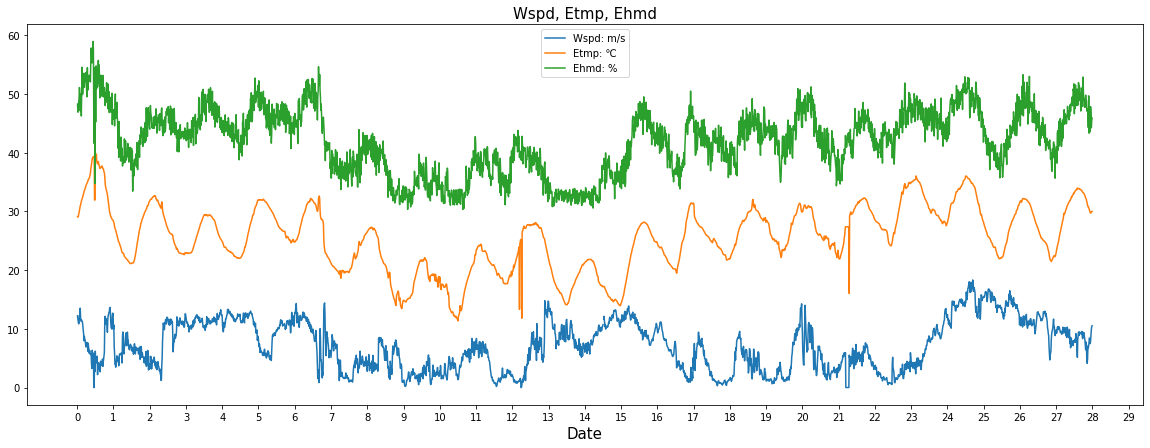

In [38]:
column = ['Wspd', 'Etmp', 'Itmp']
# li = list(range(134))
li = [0]
time = list(range(1, 2688))

time_x = []
for i in range(len(time)):
    time_x.append((time[i])/96)

TurbIDs = sorted(list(set(data['TurbID'])))
plt.figure(figsize=(20,7))
plt.xlabel('Date', size=15)
my_x_ticks = np.arange(0, 30, 1)
plt.xticks(my_x_ticks)

# my_y_ticks = np.arange(0, 40, 5)
# plt.yticks(my_y_ticks)

plt.title('Wspd, Etmp, Ehmd', size=15)

turb_data = data.loc[data['time_idx'].isin(time)]
turb_data = turb_data.loc[turb_data['TurbID'] == TurbIDs[0]].set_index('TurbID')[['Wspd']]
turb_data = turb_data.T.values[0]

plt.plot(time_x, turb_data, label='Wspd: m/s')

turb_data = data.loc[data['time_idx'].isin(time)]
turb_data = turb_data.loc[turb_data['TurbID'] == TurbIDs[0]].set_index('TurbID')[['Etmp']]
turb_data = turb_data.T.values[0]
plt.plot(time_x, turb_data, label='Etmp: ℃')

turb_data = data.loc[data['time_idx'].isin(time)]
turb_data = turb_data.loc[turb_data['TurbID'] == TurbIDs[0]].set_index('TurbID')[['Itmp']]
turb_data = turb_data.T.values[0]
plt.plot(time_x, turb_data, label='Ehmd: %')
#             plt.title(d)
plt.legend()
plt.savefig('data.pdf')
plt.show()

In [11]:
data = wspd_clip(data)
feat_columns = ['Wspd', 'Wdir', 'Etmp', 'Itmp', 'Prtv', 'Pab1', 'Pab2', 'Pab3']
data = Group_Normalization(data, feat_columns)

KeyboardInterrupt: 

In [8]:
func_li = ['wspd_clip', 'get_time_week', 'get_time_day', 'get_time_hour',
           'time_triangle', 'tmp_anomaly_replace', 'Etmp_anomaly_process',
           'Itmp_anomaly_process']

test_data_func(data, func_li)

[1]	valid_0's l2: 118464
Training until validation scores don't improve for 15 rounds
[2]	valid_0's l2: 103917
[3]	valid_0's l2: 91283.1
[4]	valid_0's l2: 80313.1
[5]	valid_0's l2: 70622.7
[6]	valid_0's l2: 62299.3
[7]	valid_0's l2: 54913.3
[8]	valid_0's l2: 48595.2
[9]	valid_0's l2: 43168.2
[10]	valid_0's l2: 38547
[11]	valid_0's l2: 34573.1
[12]	valid_0's l2: 30909.9
[13]	valid_0's l2: 27944.3
[14]	valid_0's l2: 25321.2
[15]	valid_0's l2: 22943.3
[16]	valid_0's l2: 20910.3
[17]	valid_0's l2: 19119
[18]	valid_0's l2: 17462.1
[19]	valid_0's l2: 16093.9
[20]	valid_0's l2: 14886.7
[21]	valid_0's l2: 13800.2
[22]	valid_0's l2: 12875.8
[23]	valid_0's l2: 12033.2
[24]	valid_0's l2: 11348.9
[25]	valid_0's l2: 10735.7
[26]	valid_0's l2: 10140.3
[27]	valid_0's l2: 9680.48
[28]	valid_0's l2: 9259.12
[29]	valid_0's l2: 8838.59
[30]	valid_0's l2: 8488.57
[31]	valid_0's l2: 8197.31
[32]	valid_0's l2: 7883.05
[33]	valid_0's l2: 7649.83
[34]	valid_0's l2: 7452.2
[35]	valid_0's l2: 7239.37
[36]	valid

[297]	valid_0's l2: 3792.2
[298]	valid_0's l2: 3789.51
[299]	valid_0's l2: 3788.16
[300]	valid_0's l2: 3787.23
Did not meet early stopping. Best iteration is:
[300]	valid_0's l2: 3787.23
wspd_clipperformance:
The rmse of prediction is: 82.04772491161333
The mae of prediction is: 52.70157625009542
['index', 'TurbID', 'Day', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'time_idx']
Feature importances:[2404, 3102, 2317, 4478, 606, 1184, 810, 625, 1509, 1229, 928, 2091, 2401]
[1]	valid_0's l2: 118464
Training until validation scores don't improve for 15 rounds
[2]	valid_0's l2: 103917
[3]	valid_0's l2: 91283.1
[4]	valid_0's l2: 80313.1
[5]	valid_0's l2: 70622.7
[6]	valid_0's l2: 62299.3
[7]	valid_0's l2: 54913.3
[8]	valid_0's l2: 48595.2
[9]	valid_0's l2: 43168.2
[10]	valid_0's l2: 38547
[11]	valid_0's l2: 34573.1
[12]	valid_0's l2: 30919.7
[13]	valid_0's l2: 27952.7
[14]	valid_0's l2: 25325.2
[15]	valid_0's l2: 22947.5
[16]	valid_0's l2: 20918.6
[17]	valid_0's l

[279]	valid_0's l2: 3779.86
[280]	valid_0's l2: 3780.66
[281]	valid_0's l2: 3781.63
[282]	valid_0's l2: 3780.66
[283]	valid_0's l2: 3781.76
[284]	valid_0's l2: 3781.72
[285]	valid_0's l2: 3782.13
[286]	valid_0's l2: 3781.04
[287]	valid_0's l2: 3782.27
[288]	valid_0's l2: 3776.03
[289]	valid_0's l2: 3774.57
[290]	valid_0's l2: 3773.1
[291]	valid_0's l2: 3772.72
[292]	valid_0's l2: 3771.41
[293]	valid_0's l2: 3773.35
[294]	valid_0's l2: 3771.96
[295]	valid_0's l2: 3770.58
[296]	valid_0's l2: 3769.27
[297]	valid_0's l2: 3769.19
[298]	valid_0's l2: 3768.64
[299]	valid_0's l2: 3767.99
[300]	valid_0's l2: 3765.41
Did not meet early stopping. Best iteration is:
[300]	valid_0's l2: 3765.41
get_time_weekperformance:
The rmse of prediction is: 82.42743849284992
The mae of prediction is: 53.204537183803104
['index', 'TurbID', 'Day', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'time_idx', 'time_week']
Feature importances:[2464, 3040, 1904, 4357, 573, 1122, 831, 578, 158

[260]	valid_0's l2: 3748.99
[261]	valid_0's l2: 3750.96
[262]	valid_0's l2: 3751.04
[263]	valid_0's l2: 3745.28
[264]	valid_0's l2: 3744.51
[265]	valid_0's l2: 3742.23
[266]	valid_0's l2: 3740.13
[267]	valid_0's l2: 3739.16
[268]	valid_0's l2: 3738.6
[269]	valid_0's l2: 3735.89
[270]	valid_0's l2: 3735.92
[271]	valid_0's l2: 3736.77
[272]	valid_0's l2: 3735.85
[273]	valid_0's l2: 3735.55
[274]	valid_0's l2: 3735.83
[275]	valid_0's l2: 3734.6
[276]	valid_0's l2: 3737.43
[277]	valid_0's l2: 3735.83
[278]	valid_0's l2: 3734.75
[279]	valid_0's l2: 3733.52
[280]	valid_0's l2: 3735.6
[281]	valid_0's l2: 3728.18
[282]	valid_0's l2: 3730.87
[283]	valid_0's l2: 3728.4
[284]	valid_0's l2: 3728.88
[285]	valid_0's l2: 3726.38
[286]	valid_0's l2: 3728.02
[287]	valid_0's l2: 3725.59
[288]	valid_0's l2: 3723.59
[289]	valid_0's l2: 3712.99
[290]	valid_0's l2: 3711.93
[291]	valid_0's l2: 3712.84
[292]	valid_0's l2: 3710.99
[293]	valid_0's l2: 3707.4
[294]	valid_0's l2: 3706.68
[295]	valid_0's l2: 3703.

[241]	valid_0's l2: 3784.53
[242]	valid_0's l2: 3782.62
[243]	valid_0's l2: 3786.51
[244]	valid_0's l2: 3784.42
[245]	valid_0's l2: 3783.05
[246]	valid_0's l2: 3779.53
[247]	valid_0's l2: 3776.08
[248]	valid_0's l2: 3774.92
[249]	valid_0's l2: 3772.41
[250]	valid_0's l2: 3773.4
[251]	valid_0's l2: 3766.76
[252]	valid_0's l2: 3762.47
[253]	valid_0's l2: 3761.49
[254]	valid_0's l2: 3759.62
[255]	valid_0's l2: 3756.55
[256]	valid_0's l2: 3754.79
[257]	valid_0's l2: 3753.15
[258]	valid_0's l2: 3751.5
[259]	valid_0's l2: 3750.03
[260]	valid_0's l2: 3748.99
[261]	valid_0's l2: 3750.96
[262]	valid_0's l2: 3751.04
[263]	valid_0's l2: 3745.28
[264]	valid_0's l2: 3744.51
[265]	valid_0's l2: 3742.23
[266]	valid_0's l2: 3740.13
[267]	valid_0's l2: 3739.16
[268]	valid_0's l2: 3738.6
[269]	valid_0's l2: 3735.89
[270]	valid_0's l2: 3735.92
[271]	valid_0's l2: 3736.77
[272]	valid_0's l2: 3735.85
[273]	valid_0's l2: 3735.55
[274]	valid_0's l2: 3735.83
[275]	valid_0's l2: 3734.6
[276]	valid_0's l2: 3737

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: timestamp

In [12]:
func_li = ['Group_Normalization', 'unique_avg_prtv', 'unique_avg_patv', 'no_change']

feat_columns = ['Wspd', 'Wdir', 'Etmp', 'Itmp', 'Prtv']
test_data_fc_func(data, feat_columns, func_li)

[1]	valid_0's l2: 119452
Training until validation scores don't improve for 15 rounds
[2]	valid_0's l2: 104641
[3]	valid_0's l2: 91919.4
[4]	valid_0's l2: 80841.6
[5]	valid_0's l2: 71249.4
[6]	valid_0's l2: 62926.6
[7]	valid_0's l2: 55377
[8]	valid_0's l2: 48972.1
[9]	valid_0's l2: 43275.9
[10]	valid_0's l2: 38513.8
[11]	valid_0's l2: 34223.7
[12]	valid_0's l2: 30647
[13]	valid_0's l2: 27555.3
[14]	valid_0's l2: 24842.7
[15]	valid_0's l2: 22471.6
[16]	valid_0's l2: 20371.6
[17]	valid_0's l2: 18633.3
[18]	valid_0's l2: 17068.7
[19]	valid_0's l2: 15601.1
[20]	valid_0's l2: 14408
[21]	valid_0's l2: 13314.8
[22]	valid_0's l2: 12277.1
[23]	valid_0's l2: 11484.2
[24]	valid_0's l2: 10795.7
[25]	valid_0's l2: 10164.8
[26]	valid_0's l2: 9584.53
[27]	valid_0's l2: 9031.21
[28]	valid_0's l2: 8568.75
[29]	valid_0's l2: 8212.21
[30]	valid_0's l2: 7843.89
[31]	valid_0's l2: 7511.73
[32]	valid_0's l2: 7256
[33]	valid_0's l2: 7014.44
[34]	valid_0's l2: 6823.79
[35]	valid_0's l2: 6630.53
[36]	valid_0's

[300]	valid_0's l2: 3474.54
Did not meet early stopping. Best iteration is:
[298]	valid_0's l2: 3470.64
Group_Normalizationperformance:
The rmse of prediction is: 76.93415832709101
The mae of prediction is: 47.525366648472676
['index', 'TurbID', 'Day', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'time_idx', 'Wspd_group_norm', 'Wdir_group_norm', 'Etmp_group_norm', 'Itmp_group_norm', 'Prtv_group_norm']
Feature importances:[2463, 2135, 2035, 2352, 488, 739, 538, 481, 1599, 1258, 823, 1576, 1725, 1978, 1301, 821, 710, 520]
[1]	valid_0's l2: 119460
Training until validation scores don't improve for 15 rounds
[2]	valid_0's l2: 104641
[3]	valid_0's l2: 91938
[4]	valid_0's l2: 80866.7
[5]	valid_0's l2: 71238.7
[6]	valid_0's l2: 62552.9
[7]	valid_0's l2: 55184.1
[8]	valid_0's l2: 48946.4
[9]	valid_0's l2: 43270.1
[10]	valid_0's l2: 38493
[11]	valid_0's l2: 34399.5
[12]	valid_0's l2: 30766.7
[13]	valid_0's l2: 27667.9
[14]	valid_0's l2: 25000.1
[15]	valid_0's l2: 2263

[278]	valid_0's l2: 3388.8
[279]	valid_0's l2: 3386.21
[280]	valid_0's l2: 3385.25
[281]	valid_0's l2: 3385.41
[282]	valid_0's l2: 3385.53
[283]	valid_0's l2: 3382.51
[284]	valid_0's l2: 3382.74
[285]	valid_0's l2: 3382.38
[286]	valid_0's l2: 3380.52
[287]	valid_0's l2: 3377.81
[288]	valid_0's l2: 3377.05
[289]	valid_0's l2: 3373.45
[290]	valid_0's l2: 3371.76
[291]	valid_0's l2: 3369.51
[292]	valid_0's l2: 3366.06
[293]	valid_0's l2: 3365.32
[294]	valid_0's l2: 3365.5
[295]	valid_0's l2: 3363.25
[296]	valid_0's l2: 3362.71
[297]	valid_0's l2: 3359.85
[298]	valid_0's l2: 3359.85
[299]	valid_0's l2: 3359.62
[300]	valid_0's l2: 3353.49
Did not meet early stopping. Best iteration is:
[300]	valid_0's l2: 3353.49
unique_avg_prtvperformance:
The rmse of prediction is: 76.64901381416497
The mae of prediction is: 47.64622402936439
['index', 'TurbID', 'Day', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'time_idx', 'Wspd_avg_Prtv', 'Wdir_avg_Prtv', 'Etmp_avg_Prtv', 'It

[256]	valid_0's l2: 3484.13
[257]	valid_0's l2: 3482.06
[258]	valid_0's l2: 3480.47
[259]	valid_0's l2: 3475.67
[260]	valid_0's l2: 3474.48
[261]	valid_0's l2: 3473.29
[262]	valid_0's l2: 3469.2
[263]	valid_0's l2: 3467.86
[264]	valid_0's l2: 3467.15
[265]	valid_0's l2: 3466.47
[266]	valid_0's l2: 3457.55
[267]	valid_0's l2: 3454.31
[268]	valid_0's l2: 3446.38
[269]	valid_0's l2: 3446.66
[270]	valid_0's l2: 3444.78
[271]	valid_0's l2: 3448.59
[272]	valid_0's l2: 3447.61
[273]	valid_0's l2: 3441.09
[274]	valid_0's l2: 3439.68
[275]	valid_0's l2: 3439.33
[276]	valid_0's l2: 3439.67
[277]	valid_0's l2: 3436.58
[278]	valid_0's l2: 3435.06
[279]	valid_0's l2: 3434.52
[280]	valid_0's l2: 3430.27
[281]	valid_0's l2: 3429.17
[282]	valid_0's l2: 3428.62
[283]	valid_0's l2: 3427.33
[284]	valid_0's l2: 3425.07
[285]	valid_0's l2: 3433.8
[286]	valid_0's l2: 3433.47
[287]	valid_0's l2: 3434.73
[288]	valid_0's l2: 3434.57
[289]	valid_0's l2: 3433.14
[290]	valid_0's l2: 3431.79
[291]	valid_0's l2: 34

[233]	valid_0's l2: 3487.12
[234]	valid_0's l2: 3477.68
[235]	valid_0's l2: 3478.34
[236]	valid_0's l2: 3478.2
[237]	valid_0's l2: 3476.77
[238]	valid_0's l2: 3467.38
[239]	valid_0's l2: 3466.34
[240]	valid_0's l2: 3464.92
[241]	valid_0's l2: 3463.66
[242]	valid_0's l2: 3462
[243]	valid_0's l2: 3450.22
[244]	valid_0's l2: 3447.24
[245]	valid_0's l2: 3444.38
[246]	valid_0's l2: 3444.16
[247]	valid_0's l2: 3443.73
[248]	valid_0's l2: 3442.68
[249]	valid_0's l2: 3441.19
[250]	valid_0's l2: 3441.93
[251]	valid_0's l2: 3440.54
[252]	valid_0's l2: 3439.58
[253]	valid_0's l2: 3429.7
[254]	valid_0's l2: 3427.2
[255]	valid_0's l2: 3427.19
[256]	valid_0's l2: 3424.83
[257]	valid_0's l2: 3425.12
[258]	valid_0's l2: 3422.68
[259]	valid_0's l2: 3416.04
[260]	valid_0's l2: 3408.94
[261]	valid_0's l2: 3408.21
[262]	valid_0's l2: 3401.54
[263]	valid_0's l2: 3401.59
[264]	valid_0's l2: 3401.1
[265]	valid_0's l2: 3401.13
[266]	valid_0's l2: 3401.02
[267]	valid_0's l2: 3399.69
[268]	valid_0's l2: 3398.96

In [11]:
# func_li = ['lag_feature', 'self_minus', 'rolling_mean', 'rolling_max', 'rolling_min']

func_li = ['rolling_mean', 'rolling_max', 'rolling_min']

feat_columns = ['Wspd', 'Prtv', 'Pab1', 'Pab2', 'Pab3']
li = list(range(48))
test_data_fc_li_func(data, feat_columns, li, func_li)

[1]	valid_0's l2: 119470
Training until validation scores don't improve for 15 rounds
[2]	valid_0's l2: 104729
[3]	valid_0's l2: 92015.4
[4]	valid_0's l2: 80922.8
[5]	valid_0's l2: 71267.5
[6]	valid_0's l2: 62612.8
[7]	valid_0's l2: 55410
[8]	valid_0's l2: 49112.6
[9]	valid_0's l2: 43575.9
[10]	valid_0's l2: 38636.3
[11]	valid_0's l2: 34493.1
[12]	valid_0's l2: 30965
[13]	valid_0's l2: 27849.1
[14]	valid_0's l2: 25218
[15]	valid_0's l2: 22714.5
[16]	valid_0's l2: 20622.5
[17]	valid_0's l2: 18750.3
[18]	valid_0's l2: 17117.3
[19]	valid_0's l2: 15700.4
[20]	valid_0's l2: 14522.9
[21]	valid_0's l2: 13439.9
[22]	valid_0's l2: 12510.7
[23]	valid_0's l2: 11632.8
[24]	valid_0's l2: 10876.2
[25]	valid_0's l2: 10201.7
[26]	valid_0's l2: 9671.35
[27]	valid_0's l2: 9162.82
[28]	valid_0's l2: 8670.85
[29]	valid_0's l2: 8307.7
[30]	valid_0's l2: 7972.55
[31]	valid_0's l2: 7673.59
[32]	valid_0's l2: 7377.93
[33]	valid_0's l2: 7155.34
[34]	valid_0's l2: 6954.53
[35]	valid_0's l2: 6780.25
[36]	valid_0

[297]	valid_0's l2: 3333.51
[298]	valid_0's l2: 3330.97
[299]	valid_0's l2: 3329.03
[300]	valid_0's l2: 3328.65
[301]	valid_0's l2: 3328.64
[302]	valid_0's l2: 3328.54
[303]	valid_0's l2: 3324.82
[304]	valid_0's l2: 3314.94
[305]	valid_0's l2: 3315.18
[306]	valid_0's l2: 3309.29
[307]	valid_0's l2: 3307.09
[308]	valid_0's l2: 3302.24
[309]	valid_0's l2: 3306.12
[310]	valid_0's l2: 3305.83
[311]	valid_0's l2: 3305.9
[312]	valid_0's l2: 3306.11
[313]	valid_0's l2: 3304.04
[314]	valid_0's l2: 3305.17
[315]	valid_0's l2: 3301.76
[316]	valid_0's l2: 3298.72
[317]	valid_0's l2: 3299
[318]	valid_0's l2: 3296.88
[319]	valid_0's l2: 3296.49
[320]	valid_0's l2: 3296.65
[321]	valid_0's l2: 3294.03
[322]	valid_0's l2: 3293.75
[323]	valid_0's l2: 3291.49
[324]	valid_0's l2: 3282.38
[325]	valid_0's l2: 3280.63
[326]	valid_0's l2: 3277.81
[327]	valid_0's l2: 3276.78
[328]	valid_0's l2: 3274.91
[329]	valid_0's l2: 3275.71
[330]	valid_0's l2: 3271.73
[331]	valid_0's l2: 3271.57
[332]	valid_0's l2: 3272

[1]	valid_0's l2: 119478
Training until validation scores don't improve for 15 rounds
[2]	valid_0's l2: 104759
[3]	valid_0's l2: 92058.4
[4]	valid_0's l2: 81011.5
[5]	valid_0's l2: 71325.5
[6]	valid_0's l2: 63014
[7]	valid_0's l2: 55459.6
[8]	valid_0's l2: 49248.7
[9]	valid_0's l2: 43788.8
[10]	valid_0's l2: 38959.4
[11]	valid_0's l2: 34863.3
[12]	valid_0's l2: 31118.9
[13]	valid_0's l2: 27985.2
[14]	valid_0's l2: 25203.8
[15]	valid_0's l2: 22714.6
[16]	valid_0's l2: 20633.6
[17]	valid_0's l2: 18783.1
[18]	valid_0's l2: 17216.7
[19]	valid_0's l2: 15784.9
[20]	valid_0's l2: 14518.7
[21]	valid_0's l2: 13430.8
[22]	valid_0's l2: 12481.6
[23]	valid_0's l2: 11639.7
[24]	valid_0's l2: 10877.5
[25]	valid_0's l2: 10281.8
[26]	valid_0's l2: 9690.25
[27]	valid_0's l2: 9192.61
[28]	valid_0's l2: 8740.52
[29]	valid_0's l2: 8293.74
[30]	valid_0's l2: 7923.44
[31]	valid_0's l2: 7648.78
[32]	valid_0's l2: 7323.87
[33]	valid_0's l2: 7087.95
[34]	valid_0's l2: 6876.06
[35]	valid_0's l2: 6677.94
[36]	va

[297]	valid_0's l2: 3283.5
[298]	valid_0's l2: 3283.83
[299]	valid_0's l2: 3282.26
[300]	valid_0's l2: 3282.58
[301]	valid_0's l2: 3281.64
[302]	valid_0's l2: 3281.63
[303]	valid_0's l2: 3280.85
[304]	valid_0's l2: 3280.45
[305]	valid_0's l2: 3280.58
[306]	valid_0's l2: 3275.92
[307]	valid_0's l2: 3273.91
[308]	valid_0's l2: 3259.02
[309]	valid_0's l2: 3258.22
[310]	valid_0's l2: 3256.78
[311]	valid_0's l2: 3256.03
[312]	valid_0's l2: 3251.9
[313]	valid_0's l2: 3250.98
[314]	valid_0's l2: 3250.59
[315]	valid_0's l2: 3250.46
[316]	valid_0's l2: 3250.36
[317]	valid_0's l2: 3250.61
[318]	valid_0's l2: 3248.53
[319]	valid_0's l2: 3246.31
[320]	valid_0's l2: 3245.46
[321]	valid_0's l2: 3245.88
[322]	valid_0's l2: 3245
[323]	valid_0's l2: 3243.66
[324]	valid_0's l2: 3240.08
[325]	valid_0's l2: 3240.18
[326]	valid_0's l2: 3240.09
[327]	valid_0's l2: 3239.77
[328]	valid_0's l2: 3230.72
[329]	valid_0's l2: 3230.61
[330]	valid_0's l2: 3229.33
[331]	valid_0's l2: 3228.55
[332]	valid_0's l2: 3228.

[1]	valid_0's l2: 119461
Training until validation scores don't improve for 15 rounds
[2]	valid_0's l2: 104642
[3]	valid_0's l2: 91920.3
[4]	valid_0's l2: 80841.6
[5]	valid_0's l2: 71186.5
[6]	valid_0's l2: 62527.8
[7]	valid_0's l2: 55296.4
[8]	valid_0's l2: 49010.4
[9]	valid_0's l2: 43423.9
[10]	valid_0's l2: 38529.3
[11]	valid_0's l2: 34456.7
[12]	valid_0's l2: 30735.9
[13]	valid_0's l2: 27694.8
[14]	valid_0's l2: 25003.8
[15]	valid_0's l2: 22652.6
[16]	valid_0's l2: 20570.3
[17]	valid_0's l2: 18702.6
[18]	valid_0's l2: 17117.8
[19]	valid_0's l2: 15659.5
[20]	valid_0's l2: 14420
[21]	valid_0's l2: 13330.6
[22]	valid_0's l2: 12356.7
[23]	valid_0's l2: 11540.8
[24]	valid_0's l2: 10767.5
[25]	valid_0's l2: 10130.3
[26]	valid_0's l2: 9572.12
[27]	valid_0's l2: 9056.94
[28]	valid_0's l2: 8634.01
[29]	valid_0's l2: 8246.52
[30]	valid_0's l2: 7878.12
[31]	valid_0's l2: 7568.79
[32]	valid_0's l2: 7322.3
[33]	valid_0's l2: 7092.99
[34]	valid_0's l2: 6903.24
[35]	valid_0's l2: 6723.73
[36]	val

[297]	valid_0's l2: 3423.57
[298]	valid_0's l2: 3421.8
[299]	valid_0's l2: 3422.17
[300]	valid_0's l2: 3421.02
[301]	valid_0's l2: 3417.53
[302]	valid_0's l2: 3414.82
[303]	valid_0's l2: 3414.08
[304]	valid_0's l2: 3413.77
[305]	valid_0's l2: 3407.01
[306]	valid_0's l2: 3401.52
[307]	valid_0's l2: 3401.22
[308]	valid_0's l2: 3398.72
[309]	valid_0's l2: 3397.08
[310]	valid_0's l2: 3395.06
[311]	valid_0's l2: 3394.83
[312]	valid_0's l2: 3395.02
[313]	valid_0's l2: 3387.6
[314]	valid_0's l2: 3386.43
[315]	valid_0's l2: 3386.04
[316]	valid_0's l2: 3383.03
[317]	valid_0's l2: 3382.83
[318]	valid_0's l2: 3382.62
[319]	valid_0's l2: 3382.97
[320]	valid_0's l2: 3383.37
[321]	valid_0's l2: 3381.4
[322]	valid_0's l2: 3376.28
[323]	valid_0's l2: 3373.77
[324]	valid_0's l2: 3370.99
[325]	valid_0's l2: 3370.98
[326]	valid_0's l2: 3371.67
[327]	valid_0's l2: 3371.74
[328]	valid_0's l2: 3369.7
[329]	valid_0's l2: 3368.66
[330]	valid_0's l2: 3368.04
[331]	valid_0's l2: 3366.14
[332]	valid_0's l2: 3364

In [8]:
feat_columns = ['Wspd', 'Prtv', 'Pab1', 'Pab2', 'Pab3']
# li = [list(range(144)), list(range(288)), list(range(0,144,12)), 
#       list(range(0,144,6)), list(range(0,288,12)), list(range(0,288,6))]

li = [list(range(96)), list(range(72)), list(range(48)), list(range(24))]

best_li = test_lag(data, feat_columns, li)

[1]	valid_0's l2: 119453
Training until validation scores don't improve for 15 rounds
[2]	valid_0's l2: 104654
[3]	valid_0's l2: 91949
[4]	valid_0's l2: 80885.9
[5]	valid_0's l2: 71255.1
[6]	valid_0's l2: 62607.8
[7]	valid_0's l2: 55379.8
[8]	valid_0's l2: 49091.2
[9]	valid_0's l2: 43544.9
[10]	valid_0's l2: 38614.5
[11]	valid_0's l2: 34479
[12]	valid_0's l2: 30925.7
[13]	valid_0's l2: 27822.8
[14]	valid_0's l2: 25182.6
[15]	valid_0's l2: 22832.2
[16]	valid_0's l2: 20658.1
[17]	valid_0's l2: 18835.1
[18]	valid_0's l2: 17203.8
[19]	valid_0's l2: 15815.1
[20]	valid_0's l2: 14530.9
[21]	valid_0's l2: 13420.6
[22]	valid_0's l2: 12456.6
[23]	valid_0's l2: 11618.8
[24]	valid_0's l2: 10887.9
[25]	valid_0's l2: 10280
[26]	valid_0's l2: 9723.84
[27]	valid_0's l2: 9190.12
[28]	valid_0's l2: 8767.61
[29]	valid_0's l2: 8344.89
[30]	valid_0's l2: 7998.34
[31]	valid_0's l2: 7714.49
[32]	valid_0's l2: 7389.63
[33]	valid_0's l2: 7160.14
[34]	valid_0's l2: 6950.14
[35]	valid_0's l2: 6754.74
[36]	valid_

[297]	valid_0's l2: 3329.32
[298]	valid_0's l2: 3329.27
[299]	valid_0's l2: 3325.5
[300]	valid_0's l2: 3321.56
[301]	valid_0's l2: 3314.41
[302]	valid_0's l2: 3310.59
[303]	valid_0's l2: 3308.32
[304]	valid_0's l2: 3306.89
[305]	valid_0's l2: 3306.63
[306]	valid_0's l2: 3302.24
[307]	valid_0's l2: 3298.91
[308]	valid_0's l2: 3298.34
[309]	valid_0's l2: 3292.86
[310]	valid_0's l2: 3291.18
[311]	valid_0's l2: 3286.47
[312]	valid_0's l2: 3285.49
[313]	valid_0's l2: 3283.71
[314]	valid_0's l2: 3281.06
[315]	valid_0's l2: 3279.38
[316]	valid_0's l2: 3278.76
[317]	valid_0's l2: 3278.27
[318]	valid_0's l2: 3277.72
[319]	valid_0's l2: 3277.13
[320]	valid_0's l2: 3276.32
[321]	valid_0's l2: 3275.99
[322]	valid_0's l2: 3276.72
[323]	valid_0's l2: 3275.78
[324]	valid_0's l2: 3274.81
[325]	valid_0's l2: 3274.04
[326]	valid_0's l2: 3268.61
[327]	valid_0's l2: 3269.55
[328]	valid_0's l2: 3267.85
[329]	valid_0's l2: 3267.01
[330]	valid_0's l2: 3266.37
[331]	valid_0's l2: 3263.88
[332]	valid_0's l2: 3

[591]	valid_0's l2: 3010.33
[592]	valid_0's l2: 3009.29
[593]	valid_0's l2: 3011.84
[594]	valid_0's l2: 3012.62
[595]	valid_0's l2: 3012.08
[596]	valid_0's l2: 3012.23
[597]	valid_0's l2: 3011.32
[598]	valid_0's l2: 3009.63
[599]	valid_0's l2: 3005.75
[600]	valid_0's l2: 3005.93
[601]	valid_0's l2: 3004.2
[602]	valid_0's l2: 3002.9
[603]	valid_0's l2: 2998.59
[604]	valid_0's l2: 2999.28
[605]	valid_0's l2: 2998.95
[606]	valid_0's l2: 2998.78
[607]	valid_0's l2: 2996.74
[608]	valid_0's l2: 2996.24
[609]	valid_0's l2: 2996.37
[610]	valid_0's l2: 2994.3
[611]	valid_0's l2: 2993.48
[612]	valid_0's l2: 2993.35
[613]	valid_0's l2: 2988.12
[614]	valid_0's l2: 2988.39
[615]	valid_0's l2: 2988.07
[616]	valid_0's l2: 2988.18
[617]	valid_0's l2: 2985.19
[618]	valid_0's l2: 2984.79
[619]	valid_0's l2: 2984.52
[620]	valid_0's l2: 2982.97
[621]	valid_0's l2: 2980.52
[622]	valid_0's l2: 2980.5
[623]	valid_0's l2: 2980.22
[624]	valid_0's l2: 2979.88
[625]	valid_0's l2: 2978.88
[626]	valid_0's l2: 2977

[187]	valid_0's l2: 3654.04
[188]	valid_0's l2: 3652.4
[189]	valid_0's l2: 3651.38
[190]	valid_0's l2: 3650.1
[191]	valid_0's l2: 3648.06
[192]	valid_0's l2: 3646.01
[193]	valid_0's l2: 3637.2
[194]	valid_0's l2: 3637.44
[195]	valid_0's l2: 3634.77
[196]	valid_0's l2: 3632.17
[197]	valid_0's l2: 3630.87
[198]	valid_0's l2: 3628.86
[199]	valid_0's l2: 3614.02
[200]	valid_0's l2: 3612.4
[201]	valid_0's l2: 3605.4
[202]	valid_0's l2: 3597.35
[203]	valid_0's l2: 3593.65
[204]	valid_0's l2: 3594.89
[205]	valid_0's l2: 3592.91
[206]	valid_0's l2: 3592.32
[207]	valid_0's l2: 3589.08
[208]	valid_0's l2: 3584.11
[209]	valid_0's l2: 3580.06
[210]	valid_0's l2: 3576.35
[211]	valid_0's l2: 3573.78
[212]	valid_0's l2: 3569.69
[213]	valid_0's l2: 3569.72
[214]	valid_0's l2: 3568.55
[215]	valid_0's l2: 3562.2
[216]	valid_0's l2: 3559.16
[217]	valid_0's l2: 3560.61
[218]	valid_0's l2: 3556.72
[219]	valid_0's l2: 3553.15
[220]	valid_0's l2: 3538.49
[221]	valid_0's l2: 3534.65
[222]	valid_0's l2: 3532.0

[482]	valid_0's l2: 3110.71
[483]	valid_0's l2: 3111.4
[484]	valid_0's l2: 3111.18
[485]	valid_0's l2: 3109.76
[486]	valid_0's l2: 3108.8
[487]	valid_0's l2: 3107.8
[488]	valid_0's l2: 3104.8
[489]	valid_0's l2: 3104.1
[490]	valid_0's l2: 3103.77
[491]	valid_0's l2: 3100.16
[492]	valid_0's l2: 3099.17
[493]	valid_0's l2: 3098.18
[494]	valid_0's l2: 3096.37
[495]	valid_0's l2: 3096.74
[496]	valid_0's l2: 3095.75
[497]	valid_0's l2: 3093.79
[498]	valid_0's l2: 3093.28
[499]	valid_0's l2: 3092.55
[500]	valid_0's l2: 3091.21
[501]	valid_0's l2: 3090.83
[502]	valid_0's l2: 3088.3
[503]	valid_0's l2: 3083.83
[504]	valid_0's l2: 3083.5
[505]	valid_0's l2: 3082.83
[506]	valid_0's l2: 3083.63
[507]	valid_0's l2: 3082.85
[508]	valid_0's l2: 3081.93
[509]	valid_0's l2: 3081.09
[510]	valid_0's l2: 3078.92
[511]	valid_0's l2: 3075.12
[512]	valid_0's l2: 3075.27
[513]	valid_0's l2: 3071.82
[514]	valid_0's l2: 3071.23
[515]	valid_0's l2: 3064.66
[516]	valid_0's l2: 3064.35
[517]	valid_0's l2: 3064.02

[127]	valid_0's l2: 4033.59
[128]	valid_0's l2: 4026.56
[129]	valid_0's l2: 4019.45
[130]	valid_0's l2: 4006.55
[131]	valid_0's l2: 3969.65
[132]	valid_0's l2: 3966.91
[133]	valid_0's l2: 3960.72
[134]	valid_0's l2: 3950.54
[135]	valid_0's l2: 3945.36
[136]	valid_0's l2: 3941.9
[137]	valid_0's l2: 3937.48
[138]	valid_0's l2: 3926.05
[139]	valid_0's l2: 3907.21
[140]	valid_0's l2: 3903.72
[141]	valid_0's l2: 3900.57
[142]	valid_0's l2: 3897.84
[143]	valid_0's l2: 3892.53
[144]	valid_0's l2: 3880.88
[145]	valid_0's l2: 3876.39
[146]	valid_0's l2: 3873.27
[147]	valid_0's l2: 3861.09
[148]	valid_0's l2: 3853.7
[149]	valid_0's l2: 3851.76
[150]	valid_0's l2: 3821.9
[151]	valid_0's l2: 3818.47
[152]	valid_0's l2: 3811.93
[153]	valid_0's l2: 3797.69
[154]	valid_0's l2: 3797.56
[155]	valid_0's l2: 3796.24
[156]	valid_0's l2: 3792.99
[157]	valid_0's l2: 3788.66
[158]	valid_0's l2: 3784.74
[159]	valid_0's l2: 3781.32
[160]	valid_0's l2: 3778.52
[161]	valid_0's l2: 3776.21
[162]	valid_0's l2: 376

[422]	valid_0's l2: 3117.22
[423]	valid_0's l2: 3117.74
[424]	valid_0's l2: 3118.73
[425]	valid_0's l2: 3118.3
[426]	valid_0's l2: 3114.51
[427]	valid_0's l2: 3114.67
[428]	valid_0's l2: 3112.74
[429]	valid_0's l2: 3111.32
[430]	valid_0's l2: 3109.08
[431]	valid_0's l2: 3110.22
[432]	valid_0's l2: 3111.36
[433]	valid_0's l2: 3110.67
[434]	valid_0's l2: 3110.69
[435]	valid_0's l2: 3111.85
[436]	valid_0's l2: 3106.24
[437]	valid_0's l2: 3101.4
[438]	valid_0's l2: 3100.27
[439]	valid_0's l2: 3100.44
[440]	valid_0's l2: 3099.6
[441]	valid_0's l2: 3098.19
[442]	valid_0's l2: 3099.12
[443]	valid_0's l2: 3098.6
[444]	valid_0's l2: 3097.88
[445]	valid_0's l2: 3097.84
[446]	valid_0's l2: 3098.57
[447]	valid_0's l2: 3097.93
[448]	valid_0's l2: 3097.5
[449]	valid_0's l2: 3097.19
[450]	valid_0's l2: 3096.77
[451]	valid_0's l2: 3096.05
[452]	valid_0's l2: 3095.98
[453]	valid_0's l2: 3097.11
[454]	valid_0's l2: 3095.95
[455]	valid_0's l2: 3095.71
[456]	valid_0's l2: 3096.45
[457]	valid_0's l2: 3096.

In [9]:
best_li

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47]

In [ ]:
# 画图
# Wspd, Wdir, Etmp, Itmp, Prtv, Pab1-3, Ndir
column = 'Patv'
li = list(range(134))
plot_data_TurbID(data, column, li)

In [ ]:
# column = ['Wspd', 'Wdir', 'Etmp', 'Itmp', 'Prtv', 'Pab1', 'Pab2', 'Pab3', 'Ndir', 'Patv']
column = ['Wspd', 'Prtv', 'Patv']
li = list(range(134))
time = list(range(500, 645))
plot_data_time(data, column, li, time)

In [55]:
# 试试6, 12, 144的倍数

feat_columns = ['Wspd', 'Wdir', 'Etmp', 'Itmp', 'Prtv']
li = list(range(144))
li1 = list(range(0,480,24))
for item in li1:
    if item not in li:
        li.append(item)
data = lag_feature(data, feat_columns, li)

In [63]:
data = location_id(data, location_data)

In [638]:
data = no_change(data, feat_columns)

In [ ]:
# li_roll = list(range(20))
# data = rolling_mean(data,feat_columns, li_roll)

In [601]:
feat_columns = ['Wspd', 'Wdir', 'Etmp', 'Itmp', 'Prtv']
data = Group_Normalization(data, feat_columns)

In [408]:
li_minus = list(range(10))
data = self_minus(data, feat_columns, li_minus)

In [668]:
# feat_columns = ['Wspd', 'Wdir', 'Etmp', 'Itmp']
feat_columns = ['Ndir', 'Pab1', 'Pab2', 'Pab3']
data = unique_avg_prtv(data, feat_columns)

In [6]:
# data = fillna_0(data)
# data = remove_abnormal(data)
train_feat, train_label, val_feat, val_label, test_feat, test_label, test_individual_feat, test_individual_label = dataset_split(data)

IndexError: index 38592 is out of bounds for axis 0 with size 38592

In [ ]:
# gbm = lgb_cv(train_feat, train_label, val_feat, val_label)
gbm = lgb_(train_feat, train_label, val_feat, val_label)

In [9]:
import shap
shap_explainer = shap.TreeExplainer(gbm)
shap_values = shap_explainer.shap_values(test_feat)

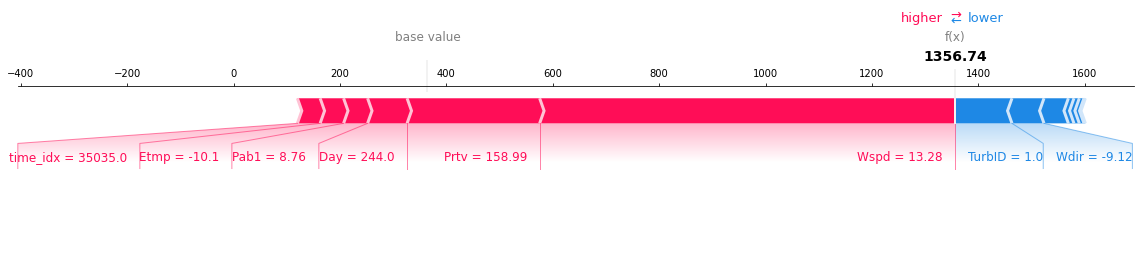

In [21]:
i = 42
shap.force_plot(shap_explainer.expected_value, shap_values[i,:], test_feat.iloc[i,:],matplotlib=True)

In [23]:
# shap.waterfall_plot(shap_explainer.expected_value, shap_values[i,:],
#                             feature_names=test_feat.columns, max_display=15, show=False)

In [ ]:
# shap.initjs()
# shap.force_plot(shap_explainer.expected_value, shap_values, test_feat)

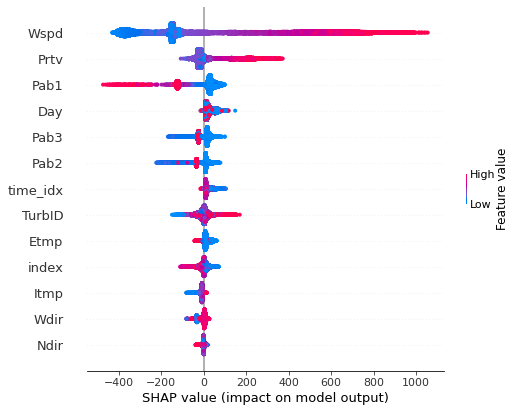

In [10]:
shap.summary_plot(shap_values, test_feat)

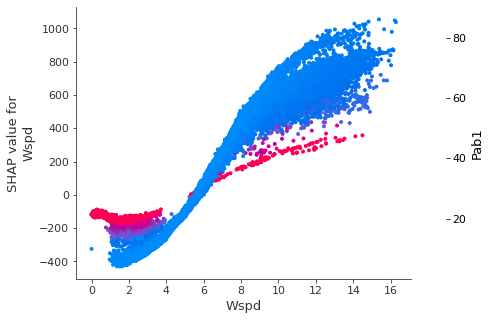

In [11]:
shap.dependence_plot('Wspd', shap_values, test_feat)

# TEST

In [25]:
lgb_test(gbm, data, test_feat, test_label)

The rmse of prediction is: 81.58642592831464
The mae of prediction is: 51.920661279761134
['index', 'TurbID', 'Day', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'time_idx', 'Wspd_group_norm', 'Wdir_group_norm', 'Etmp_group_norm', 'Itmp_group_norm', 'Prtv_group_norm', 'Pab1_group_norm', 'Pab2_group_norm', 'Pab3_group_norm']
Feature importances:[2121, 1918, 2137, 4213, 462, 664, 557, 520, 1004, 829, 609, 1709, 2130, 37, 1173, 736, 697, 411, 675, 571, 527]


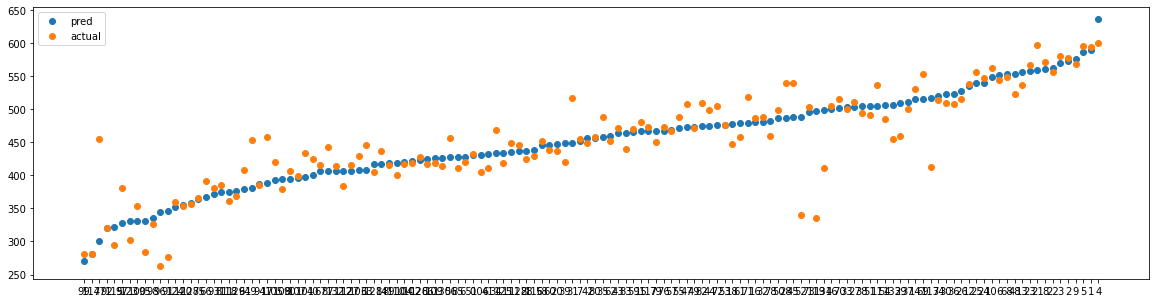

In [9]:
turb_close, turb_far = avg_compare_turb(test_individual_feat, test_individual_label, gbm)

In [65]:
# data = group(data, turb_far)
# data

In [10]:
avg_compare_time(test_individual_feat, test_individual_label, gbm)

ValueError: operands could not be broadcast together with shapes (1519,) (1678,) (1519,) 

<Figure size 1440x360 with 0 Axes>

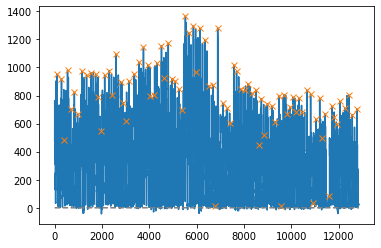

In [64]:
pred_peak_list = pred_peak(gbm.predict(test_feat), distance=100)